In [ ]:
# Placeholder for analysis code

# DOME Human Evaluation Analysis

Analysis of the results from `evaluation_results.tsv` comparison Human (A) vs Copilot (B).

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Style
sns.set_theme(style="whitegrid")

# Load data
df = pd.read_csv('evaluation_results.tsv', sep='\t')
print(f"Total evaluations: {len(df)}")
df.head()

Total evaluations: 248


,PMCID,Field,Value_A_Human,Value_B_Copilot,Rank,Comment,Timestamp
0,PMC10716825,publication/title,MLcps: machine learning cumulative performance...,MLcps: machine learning cumulative performance...,Tie_High,Full stop in copilot annotations - unnecessary,2026-01-28T18:21:52.041977
1,PMC10716825,publication/authors,"Akshay Akshay, Masoud Abedi, Navid Shekarchiza...","Akshay Akshay, Abedi Masoud, Shekarchizadeh Na...",Tie_High,NAme order difference - must specifcy preferre...,2026-01-28T18:21:54.627295
2,PMC10716825,publication/journal,GigaScience,GigaScience,Tie_High,NaN,2026-01-28T18:21:55.800229
3,PMC10716825,publication/year,2023,2022,A_Better,Wrong year extraction - 2022 correct,2026-01-28T18:21:59.161497
4,PMC10716825,publication/doi,10.1093/gigascience/giad108,10.1093/gigascience/giad108,Tie_High,NaN,2026-01-28T18:22:29.095698


## Overall Results Distribution

Rank
B_Better    121
Tie_High     59
Tie_Low      41
A_Better     27
Name: count, dtype: int64


/tmp/ipykernel_312962/1883087678.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Rank', order=['A_Better', 'B_Better', 'Tie_High', 'Tie_Low'], palette='viridis')


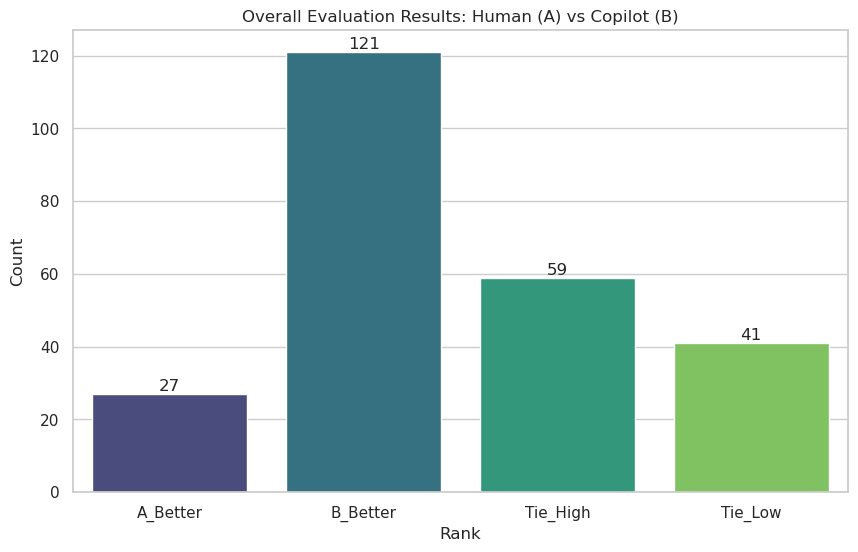

In [7]:
# Count Ranks
rank_counts = df['Rank'].value_counts()
print(rank_counts)

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Rank', order=['A_Better', 'B_Better', 'Tie_High', 'Tie_Low'], palette='viridis')
plt.title('Overall Evaluation Results: Human (A) vs Copilot (B)')
plt.ylabel('Count')

# Add labels
for container in ax.containers:
    ax.bar_label(container)

plt.show()

## Win Rate Analysis
Aggregating 'Tie_High' and 'Tie_Low' into a single 'Tie' category to compare win rates.

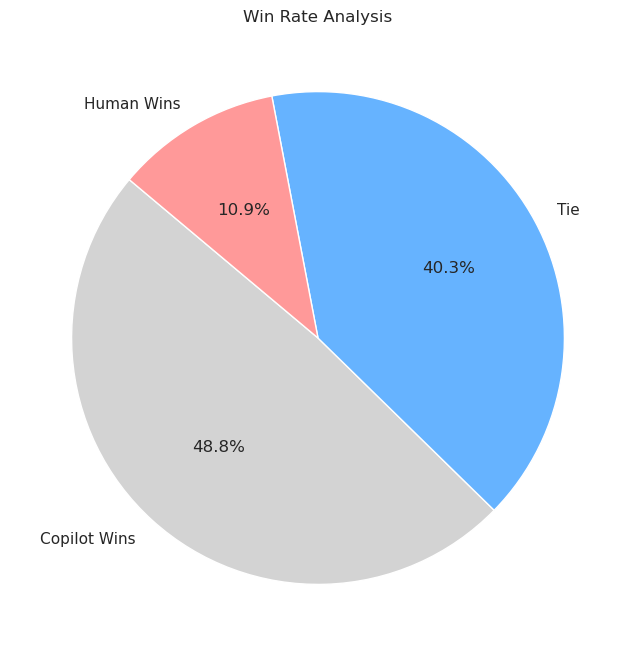

In [8]:
def categorize_result(rank):
    if rank == 'A_Better': return 'Human Wins'
    if rank == 'B_Better': return 'Copilot Wins'
    return 'Tie'

df['Outcome'] = df['Rank'].apply(categorize_result)

outcome_counts = df['Outcome'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightgray', '#66b3ff', '#ff9999'])
plt.title('Win Rate Analysis')
plt.show()

## Performance by Field
Which fields does Copilot struggle with compared to Human?

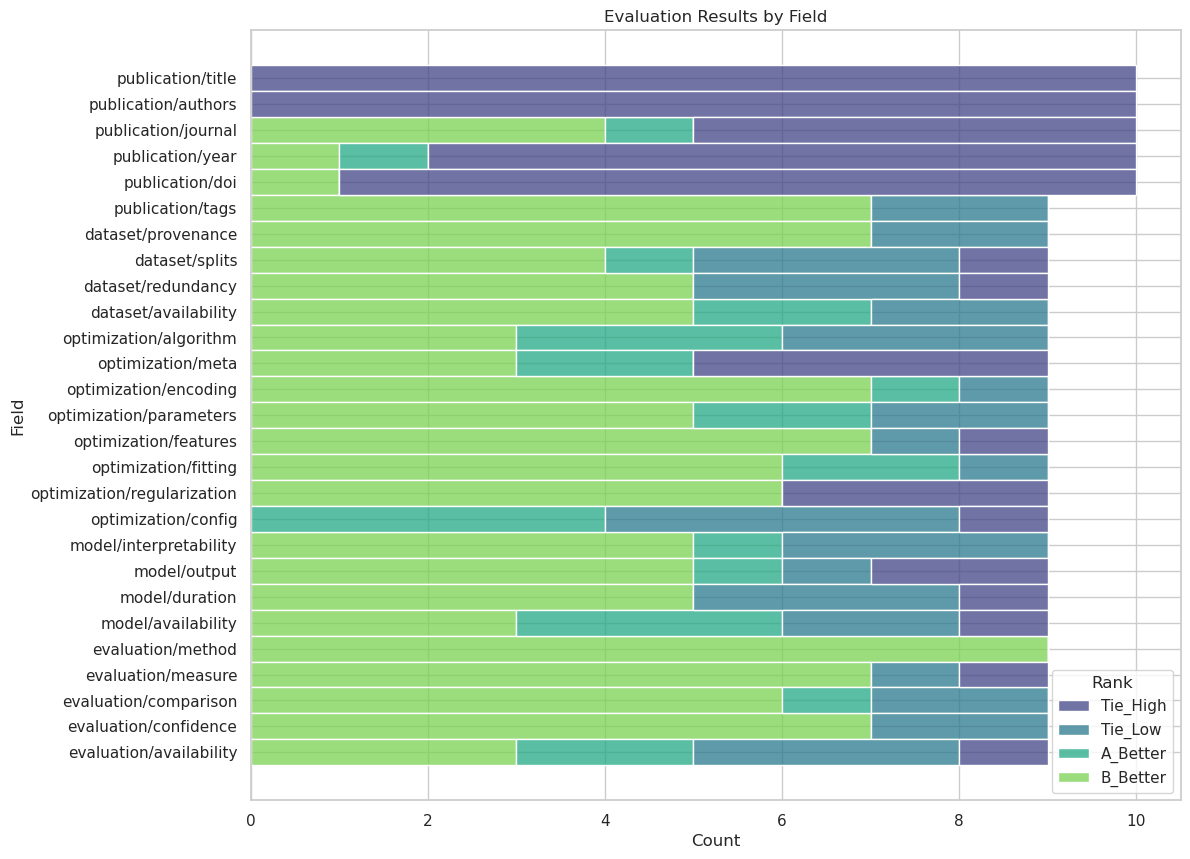

In [9]:
plt.figure(figsize=(12, 10))
sns.histplot(data=df, y='Field', hue='Rank', multiple='stack', hue_order=['Tie_High', 'Tie_Low', 'A_Better', 'B_Better'], palette='viridis')
plt.title('Evaluation Results by Field')
plt.xlabel('Count')
plt.show()

## Copilot Win Rate per Field
Calculating the percentage of times Copilot (B) was rated better than Human (A) for each field.

/tmp/ipykernel_312962/743422158.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=field_stats['Copilot_Win_Rate'], y=field_stats.index, palette='Blues_r')


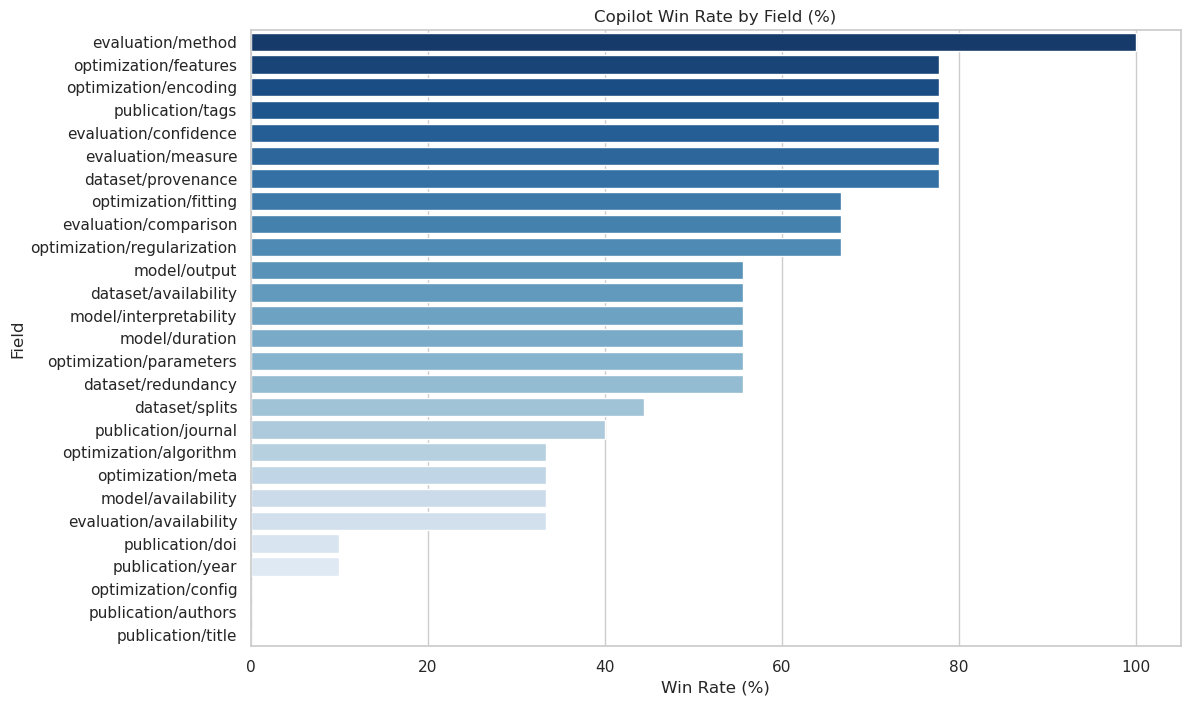

In [10]:
# Calculate B_Better percentage per field
field_stats = df.groupby('Field')['Rank'].value_counts(normalize=True).unstack().fillna(0)
if 'B_Better' in field_stats.columns:
    field_stats['Copilot_Win_Rate'] = field_stats['B_Better'] * 100
else:
    field_stats['Copilot_Win_Rate'] = 0
    
field_stats = field_stats.sort_values('Copilot_Win_Rate', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=field_stats['Copilot_Win_Rate'], y=field_stats.index, palette='Blues_r')
plt.title('Copilot Win Rate by Field (%)')
plt.xlabel('Win Rate (%)')
plt.show()

## 30 Evaluation Diversity Analysis
Analysis of the 30 processed entries by Journal, Curator, Annotation Length, and Supplementary Files.

Loading User and DOI Mappings...
Processing 30 folders...


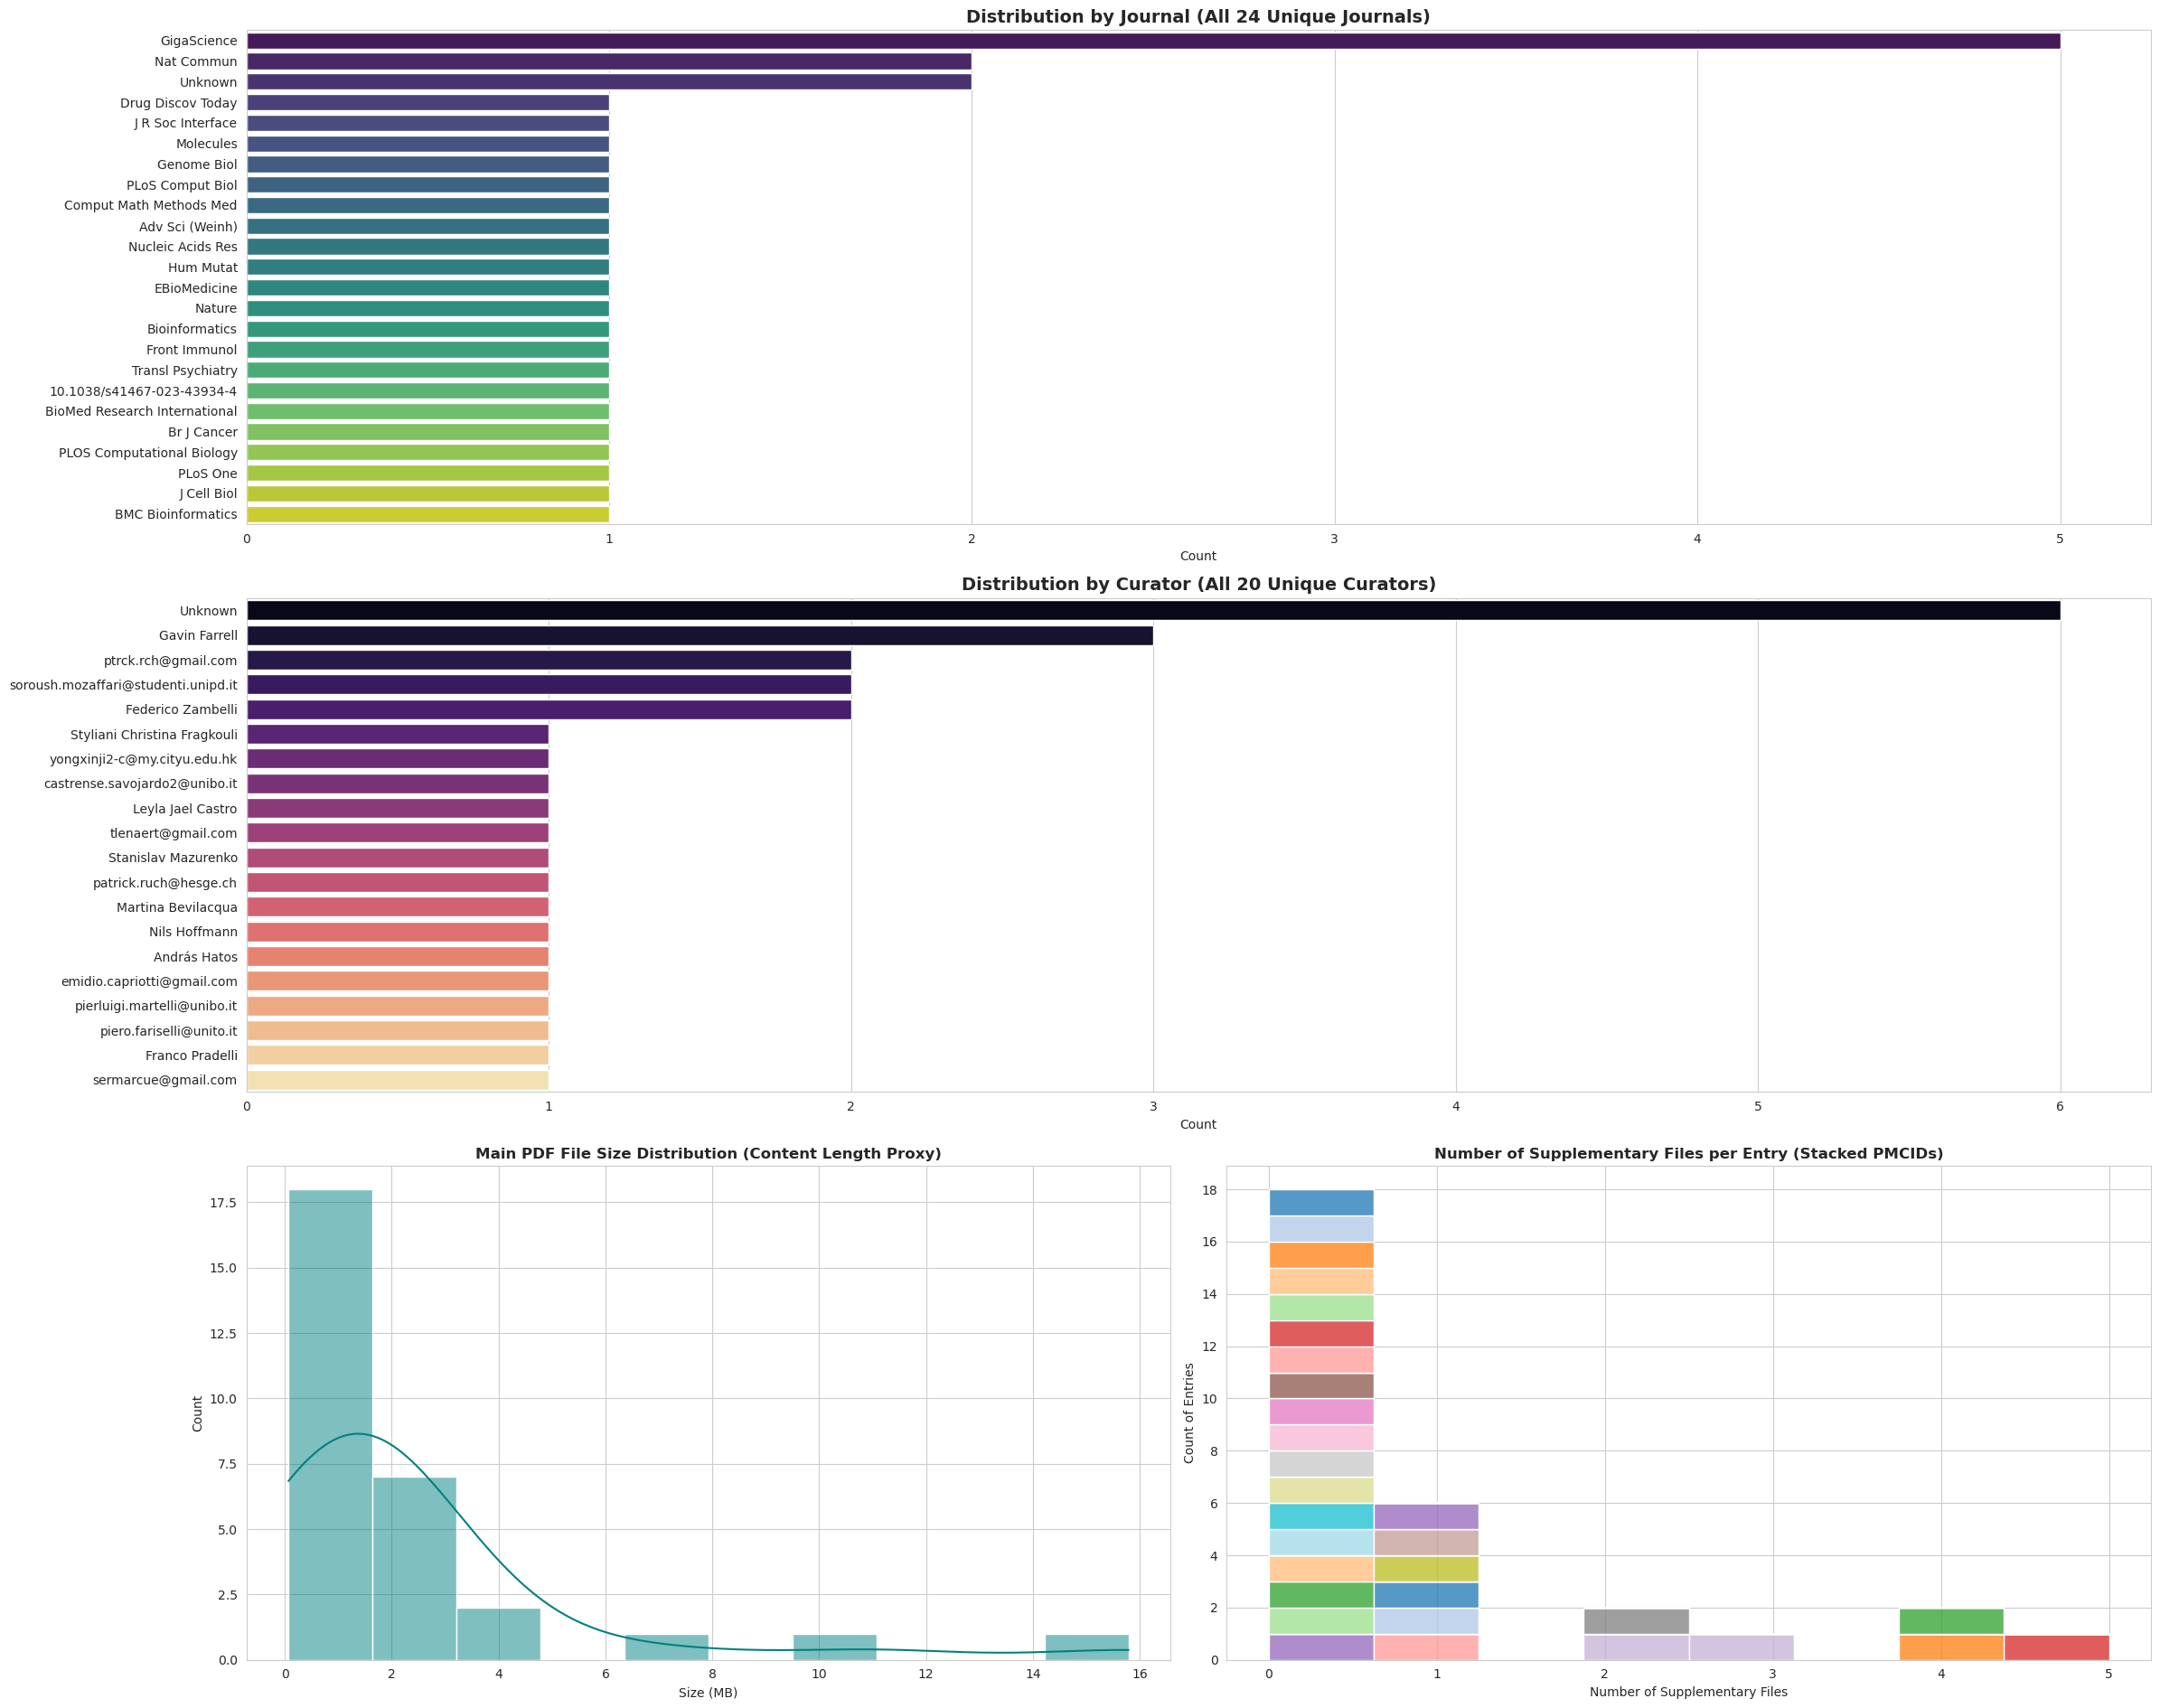


=== Diversity Summary ===
Total Entries: 30
Unique Journals: 24
Unique Curators: 20
Avg Main PDF Size: 2.50 MB
Avg Supplementary Files: 0.9
Entries with 0 Supplementary Files: 18


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import json
import os
import glob
import numpy as np

# Configuration
DATA_DIR = "../30_human_evaluation"
REGISTRY_DIR = "../DOME_Registry_JSON_Files"
RAW_REVIEWS_FILE = "dome_review_raw_human_20260128.json"
USERS_FILE = "dome_users_20260130.json"

# 1. Load Mappings
print("Loading User and DOI Mappings...")
doi_to_oid = {}
oid_to_user = {}

# Load DOI -> OID
try:
    with open(os.path.join(REGISTRY_DIR, RAW_REVIEWS_FILE), 'r', encoding='utf-8') as f:
        reviews_data = json.load(f)
        for entry in reviews_data:
            doi = entry.get('publication', {}).get('doi', '')
            oid = entry.get('user', {}).get('$oid', '')
            if doi and oid:
                doi_to_oid[doi.strip()] = oid
except Exception as e:
    print(f"Error loading reviews: {e}")

# Load OID -> User
try:
    with open(os.path.join(REGISTRY_DIR, USERS_FILE), 'r', encoding='utf-8') as f:
        users_data = json.load(f)
        for u in users_data:
            oid = u.get('_id', {}).get('$oid', '')
            if oid:
                name = f"{u.get('name', '')} {u.get('surname', '')}".strip()
                if not name and u.get('email'):
                    name = u.get('email')
                if not name:
                    name = "Unknown"
                oid_to_user[oid] = name
except Exception as e:
    print(f"Error loading users: {e}")

# 2. Collect Data
stats_list = []
pmc_folders = glob.glob(os.path.join(DATA_DIR, "PMC*"))

print(f"Processing {len(pmc_folders)} folders...")

for folder in pmc_folders:
    pmcid = os.path.basename(folder)
    human_json_path = os.path.join(folder, f"{pmcid}_human.json")
    main_pdf_path = os.path.join(folder, f"{pmcid}_main.pdf")
    
    # Defaults
    journal = "Unknown"
    curator = "Unknown"
    annot_length = 0
    supp_count = 0
    pdf_size_mb = 0
    
    # Read Metadata from Human JSON
    if os.path.exists(human_json_path):
        try:
            with open(human_json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                journal = data.get('publication/journal', 'Unknown')
                doi = data.get('publication/doi', '').strip()
                
                # Resolve Curator
                if doi in doi_to_oid:
                    oid = doi_to_oid[doi]
                    curator = oid_to_user.get(oid, "Unknown ID")
        except:
            pass
            
    # Count Supplementaries
    pdfs = glob.glob(os.path.join(folder, "*.pdf"))
    # Exclude main PDF
    supp_pdfs = [p for p in pdfs if os.path.abspath(p) != os.path.abspath(main_pdf_path)]
    supp_count = len(supp_pdfs)
    
    # PDF Size
    if os.path.exists(main_pdf_path):
        pdf_size_mb = os.path.getsize(main_pdf_path) / (1024 * 1024)
        
    stats_list.append({
        'PMCID': pmcid,
        'Journal': journal,
        'Curator': curator,
        'Supplementary_Files_Count': supp_count,
        'Main_PDF_Size_MB': pdf_size_mb
    })

df_stats = pd.DataFrame(stats_list)

# 3. Visualization
sns.set_style("whitegrid")
fig = plt.figure(figsize=(24, 20)) # Increased size for readability 
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1])

# Plot 1: Journal Distribution (ALL)
ax1 = fig.add_subplot(gs[0, :])
journal_counts = df_stats['Journal'].value_counts()
sns.barplot(x=journal_counts.values, y=journal_counts.index, ax=ax1, palette="viridis", hue=journal_counts.index, legend=False)
ax1.set_title(f'Distribution by Journal (All {len(journal_counts)} Unique Journals)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Count')
ax1.set_ylabel('')

# Plot 2: Curator Distribution (ALL)
ax2 = fig.add_subplot(gs[1, :])
curator_counts = df_stats['Curator'].value_counts()
sns.barplot(x=curator_counts.values, y=curator_counts.index, ax=ax2, palette="magma", hue=curator_counts.index, legend=False)
ax2.set_title(f'Distribution by Curator (All {len(curator_counts)} Unique Curators)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Count')
ax2.set_ylabel('')

# Plot 3: PDF Size (Content Length)
ax3 = fig.add_subplot(gs[2, 0])
sns.histplot(data=df_stats, x='Main_PDF_Size_MB', bins=10, ax=ax3, kde=True, color='teal')
ax3.set_title('Main PDF File Size Distribution (Content Length Proxy)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Size (MB)')

# Plot 4: Supplementary Files Count (Stacked by PMCID)
ax4 = fig.add_subplot(gs[2, 1])
# We want to stack the PMCIDs. `multiple='stack'` does this automatically with `hue`.
# We ensure X axis looks good (integers)
sns.histplot(data=df_stats, x='Supplementary_Files_Count', hue='PMCID', multiple='stack', ax=ax4, legend=False, palette='tab20')
ax4.set_title('Number of Supplementary Files per Entry (Stacked PMCIDs)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Number of Supplementary Files')
ax4.set_ylabel('Count of Entries')
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
ax4.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# Display Summary Stats
print("\n=== Diversity Summary ===")
print(f"Total Entries: {len(df_stats)}")
print(f"Unique Journals: {df_stats['Journal'].nunique()}")
print(f"Unique Curators: {df_stats['Curator'].nunique()}")
print(f"Avg Main PDF Size: {df_stats['Main_PDF_Size_MB'].mean():.2f} MB")
print(f"Avg Supplementary Files: {df_stats['Supplementary_Files_Count'].mean():.1f}")
print(f"Entries with 0 Supplementary Files: {len(df_stats[df_stats['Supplementary_Files_Count'] == 0])}")

In [ ]:
# Lookup functionality for specific paper
target_doi = "10.1371/journal.pone.0139571"
target_title = "PATBox: A Toolbox for Classification and Analysis of P-Type ATPases."
target_pmid = "26422234"

print(f"--- Annotator Lookup ---")
print(f"Query: {target_title}")
print(f"DOI: {target_doi}")

# 1. Quick Map Lookup
if target_doi in doi_to_oid:
    oid = doi_to_oid[target_doi]
    annotator = oid_to_user.get(oid, "Unknown User")
    print(f"\nResult (from DOI Match):")
    print(f"Annotator: {annotator}")
else:
    print("\nDirect DOI match failed. Searching raw records...")
    
    # 2. Deep Search
    found = False
    try:
        # scan the file directly to be sure
        with open(os.path.join(REGISTRY_DIR, RAW_REVIEWS_FILE), 'r', encoding='utf-8') as f:
            reviews = json.load(f)
            
        for entry in reviews:
            pub = entry.get('publication', {})
            # Get fields safely
            curr_doi = str(pub.get('doi', ''))
            curr_title = str(pub.get('title', ''))
            curr_pmid = str(pub.get('pmid', ''))
            
            # Check for matches
            match_doi = target_doi in curr_doi
            match_pmid = target_pmid in curr_pmid
            match_title = target_title.lower() in curr_title.lower()
            
            if match_doi or match_pmid or match_title:
                user_oid = entry.get('user', {}).get('$oid', '')
                user_name = oid_to_user.get(user_oid, "Unknown Name")
                
                print(f"\nMatch Found in Registry!")
                print(f"  Title: {curr_title}")
                print(f"  DOI: {curr_doi}")
                print(f"  PMID: {curr_pmid}")
                print(f"  Annotator: {user_name}")
                found = True
                break
                
        if not found:
            print("  No matching record found in DOME registry.")
            
    except Exception as e:
        print(f"Error during search: {e}")

--- Annotator Lookup ---
Query: Highly accurate protein structure prediction with AlphaFold
DOI: 10.1038/s41586-021-03819-2

Result (from DOI Match):
Annotator: Gavin Farrell
